# Bloated real-estate market!

In [27]:
#!pip install scipy
#!pip install matplotlib
#!pip install seaborn
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Part 1: Loading the data

With more than 1 million flats spread across 24 towns and 3 estates, the Singapore brand of public housing is uniquely different. The flats spell home for over 80% of Singapore's resident population, of which, about 90% own their home. 

Data.gov is a repository of many datasets that are made available by different public service bodies in Singapore. This project will work on [HDB Resale Price](https://data.gov.sg/dataset/resale-flat-prices) available through the same datastore. It houses the resale price data from January 1990 to December 2020 on a monthly basis. We will be working on the resale records from 2000 to 2020.

Let's start exploring this dataset.

In [28]:
import re
import os
from google.colab import drive
drive.mount('/content/drive/')
dirpath = '/content/drive/MyDrive/IT5006/HDB/'
#dirpath = 'HDB/'

resalefiles = [x for x in os.listdir(dirpath) if re.match(r'^resale*',os.path.splitext(x)[0]) and os.path.splitext(x)[-1] == '.csv']

resales = pd.read_csv(dirpath + resalefiles[0])
for i in range(1,len(resalefiles)):
  temp = pd.read_csv(dirpath + resalefiles[i])
  resales = resales.append(temp)
resales = resales.reset_index(drop = True)
resales['month'] = pd.to_datetime(resales['month'], format='%Y-%m')
resales['lease_commence_date'] = pd.to_datetime(resales['lease_commence_date'], format = '%Y')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Part 2: Data Imputation

Print the count of missing values in every column of the  dataframe.

In [29]:
missing_values_count = resales.isnull().sum()
print(missing_values_count)

month                       0
town                        0
flat_type                   0
block                       0
street_name                 0
storey_range                0
floor_area_sqm              0
flat_model                  0
lease_commence_date         0
resale_price                0
remaining_lease        709050
dtype: int64


We observe that the `remaining_lease` feature has multiple missing values. Impute the missing values and ensure that the dataframe does not contain any missing value.

*Hint: What is the lease period of every HDB flat in Singapore? [ Find out here.](https://www.gov.sg/article/do-i-really-own-my-hdb-flat)*

In [30]:
# Functions
#convert duration to timedelta (input X years Y months, output timedelta X * 365 + month * 30)
def convert_duration_to_timedelta(duration):
    if type(duration) == str :
        words = duration.split()
        years = int(words[0].strip().split(' ')[0])
        months = int(words[2].strip().split(' ')[0]) if len(words) > 2 else 0
        return pd.Timedelta(days= years * 365 + months * 30)
    else:
       return #NaN

# Convert timedelta to duration
def convert_timedelta_to_duration(timedelta):
   
    td = pd.Timedelta(days=365)

    total_days = timedelta.total_seconds() / (24 * 60 * 60)

    years = int(total_days // 365)
    months = int((total_days % 365) // 30)
    if months == 12:
       years += 1
       months = 0
    return str(years) + ' years ' + str(months) + 'months' if months != 0 else str(years) + ' years'

In [31]:
# Create a key to connect the same building
resales['address_detail'] = resales['town']+ '_'+ resales['street_name'] + '_'+ resales['block']

resales.sort_values(by='month', axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last')
# Convert str to timedelta for calculation
resales['remaining_lease'] = resales['remaining_lease'].apply(convert_duration_to_timedelta)
resales['expire_date'] = resales['month'] + resales['remaining_lease']
resales['expire_date'] = resales['expire_date'].mask(resales["remaining_lease"].isna())
# Fill the nan data
resales['expire_date'] = resales.groupby('address_detail')['expire_date'].bfill()
# For those data that can not bfilled, use 99years - lease_commence_date to get the remaining_lease
resales['expire_date'].fillna(resales['lease_commence_date'] + pd.Timedelta(days=99 * 365), inplace= True)
resales['remaining_lease'] = (resales['expire_date'] - resales['month']).apply(convert_timedelta_to_duration)
print(resales['remaining_lease'])

605301     87 years 3months
605477     94 years 1months
605476     94 years 3months
605475     94 years 3months
605474     94 years 2months
                ...        
565963    59 years 10months
565962     91 years 2months
565961     63 years 5months
565959     53 years 5months
565762     68 years 7months
Name: remaining_lease, Length: 891721, dtype: object


Create a new feature `price_per_sqm` that lists the price per square meter of the resale record.


In [32]:
resales['price_per_sqm'] = resales['resale_price']/ resales['floor_area_sqm']
print(resales['price_per_sqm'])

605301     358.108108
605477     806.481481
605476    1009.708738
605475    1009.615385
605474     814.814815
             ...     
565963    5671.641791
565962    6978.723404
565961    6575.342466
565959    5299.145299
565762    4652.769231
Name: price_per_sqm, Length: 891721, dtype: float64


## Part 3: Data Visualisation

Create four different data panels from the original dataframe.
- First panel contains the records from January 2018 to December 2018
- Second panel contains the records from January 2019 to December 2019
- Third panel contains the records from January 2020 to December 2020
- Fourth panel contains the records from January 2021 to December 2021

In order to do so, create a column `panel` that contains the panel number for every datapoint

In [33]:
# Default panel = 0
resales['panel'] = 0
# Assign panel according to the statement
resales.loc[(resales['month'] >= '2018-01-01') & (resales['month'] <= '2018-12-31'), 'panel'] = 1
resales.loc[(resales['month'] >= '2019-01-01') & (resales['month'] <= '2019-12-31'), 'panel'] = 2
resales.loc[(resales['month'] >= '2020-01-01') & (resales['month'] <= '2020-12-31'), 'panel'] = 3
resales.loc[(resales['month'] >= '2021-01-01') & (resales['month'] <= '2021-12-31'), 'panel'] = 4

For every panel, show a lineplot of resale prices versus the time, colour-coded by `flat_type`. Only include *5 ROOM, 4 ROOM, 3 ROOM, 2 ROOM, 1 ROOM* types in the lineplot.  Please ensure following things: 
- Four plots must be in one row with the leftmost plot displaying the first panel and the rightmost displaying the fourth panel.
- All plots must share the same range of resale prices on their `y` axes.
- Colour coding for the `flat_type` must be consistent across the panels.
- The entire plot should have the title: "Resale Prices of Different Flat Types"


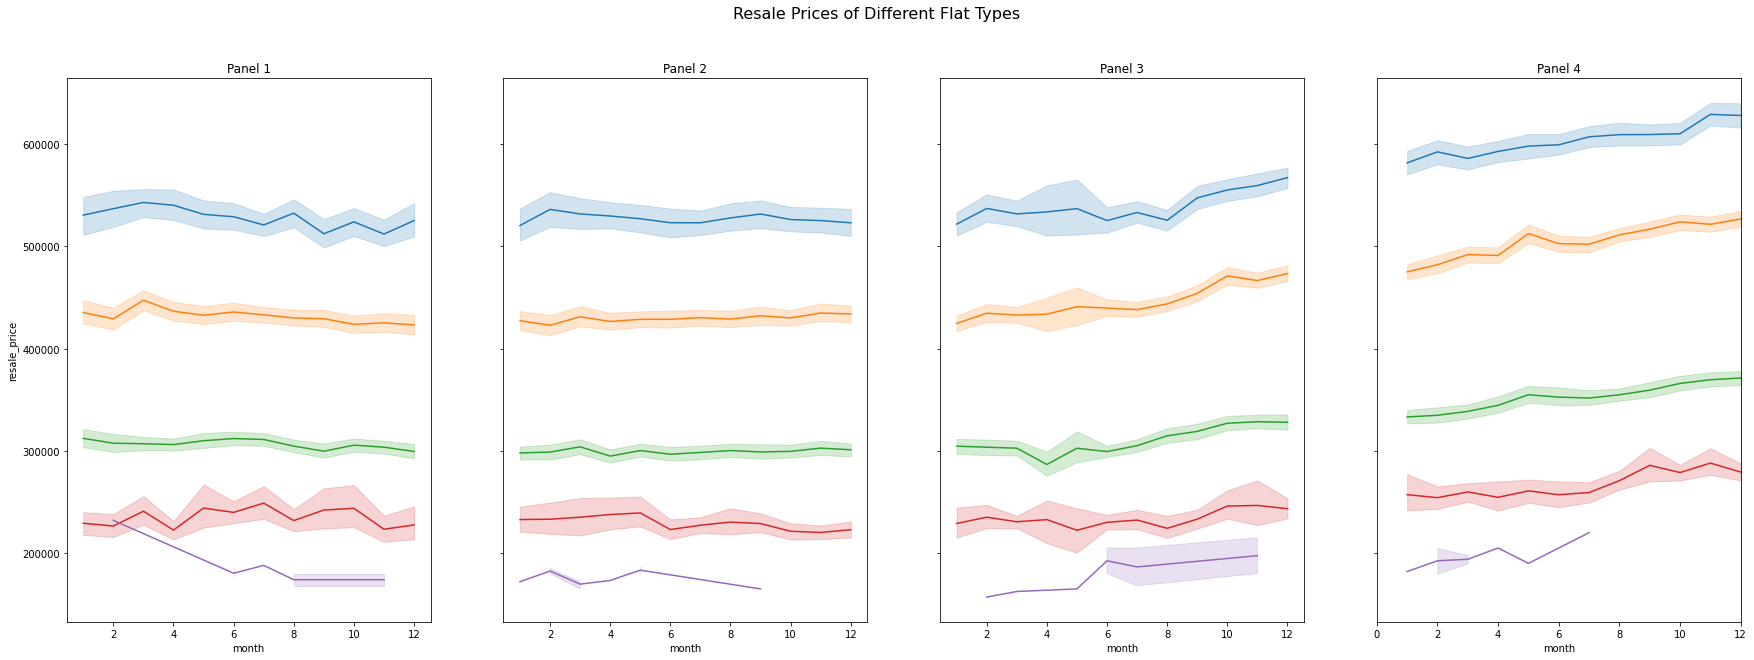

In [34]:
# Selected room type
roomfilter = ['5 ROOM','4 ROOM','3 ROOM','2 ROOM','1 ROOM']
roomcolor_avg = {'5 ROOM':'red', '4 ROOM': "orange" , '3 ROOM':'purple', '2 ROOM':'green', '1 ROOM':'blue'}
roomcolor_fill =  {'5 ROOM':'mistyrose', '4 ROOM': "moccasin" , '3 ROOM':'#dfc5fe', '2 ROOM':'lightgreen', '1 ROOM':'lightblue'}
colors = ['red', 'orange', 'yellow', 'green', 'blue']
# Select needed rooms
aim_rooms = resales[(resales['flat_type'].isin(roomfilter)) & (resales['panel'].isin([1,2,3,4]))]
# Configure figure
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(30,10))
axs = (ax1, ax2, ax3, ax4)

# Create the line plots
for i in range(1, 5):
    for flat_type, color in roomcolor_avg.items():
      data = aim_rooms[(aim_rooms['flat_type'] == flat_type) & (aim_rooms['panel'] == i)][['month','resale_price']]
      sns.lineplot(x = data['month'].dt.month, y='resale_price', data=data, ax=axs[i-1])
    plt.xlim(left = 0, right = 12)
    axs[i-1].set(title='Panel {}'.format(i))

# Set the title for the entire plot
plt.suptitle('Resale Prices of Different Flat Types', fontsize=16)

# Show the plot
plt.show()


# Part 4: Bootstrap and Confidence Intervals

- Generates 1000 bootstrap samples.
- Compute sample mean for `price_per_sqm` for every sample.
- Plot a histogram of mean (does it not look like a normal distribution!)
- This is for better understanding bootstrap and confidence intervals!

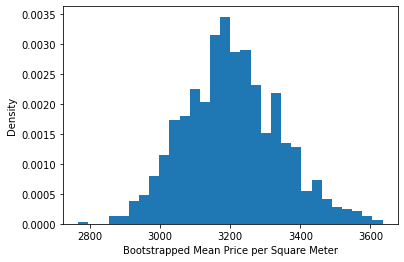

In [35]:
# Generate 1000 bootstrap samples
n_bootstraps = 1000
bootstrapped_means = np.empty(n_bootstraps)
for i in range(n_bootstraps):
    bootstrapped_sample = resales.sample(n=100, replace=True)
    bootstrapped_means[i] = bootstrapped_sample['price_per_sqm'].mean()

# Plot a histogram of the bootstrapped means
plt.hist(bootstrapped_means, bins=30, density=True)
plt.xlabel("Bootstrapped Mean Price per Square Meter")
plt.ylabel("Density")
plt.show()

Generate 95% confidence interval for the (population) mean of `price_per_sqm` using the bootstrap samples.

In [36]:
# Calculate the mean of the bootstrapped means
mean = np.mean(bootstrapped_means)

# Calculate the standard error of the bootstrapped means
standard_error = np.std(bootstrapped_means)

from scipy.stats import norm
# Set confidence level
confidence_level = 0.95
# Calculate the alpha
z_alpha = norm.ppf((1 + confidence_level) / 2)

# Calculate the lower and upper bounds of the 95% confidence interval
lower_bound = mean - z_alpha * standard_error
upper_bound = mean + z_alpha * standard_error

print("95% Confidence Interval: [{:.2f}, {:.2f}]".format(lower_bound, upper_bound))


95% Confidence Interval: [2937.77, 3473.88]


Does the population mean lie inside it?


In [37]:
pop_mean = resales['price_per_sqm'].mean()
print("Population mean is : {:.2f}".format(pop_mean))
if pop_mean <= upper_bound and pop_mean >= lower_bound:
  print("Yes")
else:
  print("No")

Population mean is : 3204.43
Yes


## Part 5: Growing Resale Prices!

In 2019, the rental cost of a 3BR HDB in Clementi used to be around 2500 dollars, and now it has reached as high as 4100. dollars. Some analysis shows that it is caused due to COVID. Well, we are not sure about that yet!

Is it true about the resale prices as well? Is there some correlation? Let's analyse the growth of various areas in Singapore.

- Compute the *median* `price_per_sqm` of houses in various areas in 2019 and 2022.
- We define *growth* as the normalised difference between the median housing `price_per_sqm` in 2019 and 2022, i.e. *(price_per_sqm_2022 - price_per_sqm_2019) / price_per_sqm_2019*. Compute `growth` of various areas in Singapore.
- Create a dataframe that contains four columns: `town`, `2019_median`, `2022_median` and `growth`. Print the dataframe sorted in descending order of the growth.



In [38]:
# Compute the median price_per_sqm of houses ivarious areas in 2019 and 2022
price_per_sqm_2019 = resales[(resales['month'] >= '2019-01-01') & (resales['month'] <= '2019-12-31')].groupby('town')['price_per_sqm'].median().reset_index()
price_per_sqm_2022 = resales[(resales['month'] >= '2022-01-01') & (resales['month'] <= '2022-12-31')].groupby('town')['price_per_sqm'].median().reset_index()
price_per_sqm_2019.rename(columns={"price_per_sqm": "2019_median"}, inplace=True)
price_per_sqm_2022.rename(columns={"price_per_sqm": "2022_median"}, inplace=True)
#print(price_per_sqm_2019)
#print(price_per_sqm_2022)

# Create the needed dataframe, add the growth column
growth_19_22 = pd.merge(price_per_sqm_2019, price_per_sqm_2022, on='town')
growth_19_22['growth'] = (price_per_sqm_2022['2022_median'] - price_per_sqm_2019['2019_median']) / price_per_sqm_2019['2019_median']
#print(growth_19_22)

print(growth_19_22.sort_values(by='growth', ascending=False))

               town  2019_median  2022_median    growth
8     CHOA CHU KANG  3367.934426  4888.888889  0.451599
19        SEMBAWANG  3664.122137  5284.050179  0.442105
24        WOODLANDS  3445.799060  4779.411765  0.387026
3       BUKIT BATOK  3750.000000  5130.156318  0.368042
25           YISHUN  3838.121118  5140.186916  0.339246
14  KALLANG/WHAMPOA  5283.882784  7000.000000  0.324783
13      JURONG WEST  3719.008264  4864.864865  0.308108
0        ANG MO KIO  4117.647059  5328.911501  0.294164
11          HOUGANG  4047.619048  5238.095238  0.294118
23        TOA PAYOH  4444.444444  5692.307692  0.280769
16        PASIR RIS  3923.809524  4952.380952  0.262136
12      JURONG EAST  4029.850746  5069.933490  0.258095
9          CLEMENTI  4705.882353  5867.618430  0.246869
1             BEDOK  4191.176471  5212.121212  0.243594
20         SENGKANG  4500.000000  5580.645161  0.240143
21        SERANGOON  4621.848739  5699.802502  0.233230
10          GEYLANG  4565.217391  5589.012048  0

Question:
Do some research to qualitatively reason why COVID might have caused this surge in resale prices.

While inflation naturally causes prices to rise over time, the COVID-19 pandemic has likely contributed to a faster pace of increase. According to *the Law of Supply and Demand*, the price of a commodity rises when the demand exceeds supply. Based on this, I have got two reasons for why the pandemic have caused the surge in housing resale prices in Singapore:

**1.People spend more time at home:**
Firstly, with the pandemic keeping many people to work from home, reduce unnecessary outings, citizens are spending more time at home. They may wantt to have more activities at home, which needs space. Therefore, people have higher demand on their house condition and space during the pandemic. Secondly, spending more time at home has made more people aware of the importance of owning their own house. These two aspects result in increasing demand for houses and thus has led to a surge in resale prices.

**2.Search for a Stable Investment:**
The pandemic has had a profound impact on many industries, resulting in unemployment and bankruptcies. Living in such an uncertain environment, many people are looking for a safe and stable investment. Real estate has become an attractive option for many. As a result, the demand for properties increases while the supply decreases, leading to the surge of resale prices.